<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<br><br><br><br><br>

# Battle of the Neighborhoods: Opening a Gym in MA, USA

> _by Jack Daoud_
>
> _May 15<sup>nd</sup>, 2021_


<br><br><br><br>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<br><br>


# Table of Contents
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<font size="4">1. </font>[<font size="4">Data</font>](#data)

>
> <font size="3">i. </font>[<font size="3">Neighborhood Data</font>](#city)
>
> <font size="3">ii. </font>[<font size="3">Housing Price Data</font>](#housing)
>
> <font size="3">iii. </font>[<font size="3">Foursquare Data</font>](#foursquare)

<font size="4">3. </font>[<font size="4">Clustering</font>](#clustering)

>
> <font size="3">i. </font>[<font size="3">Data Preparation</font>](#dataprep)
>
> <font size="3">ii. </font>[<font size="3">Clustering Algorithm</font>](#algorithm)


<br><br><br><br><br><br>

# 1) Data
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<a id='data'></a>

In [1]:
# Packages

import json
import folium
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

<br>

## 2.1) Neighborhood Data

<a id='city'></a>

This section includes wrangling & mapping of location data from [UnitedStatesZipCodes.org](https://www.unitedstateszipcodes.org/zip-code-database/).

In [2]:
# Neighborhood Data

# Import data
df_neighborhood = pd.read_csv('_data/zip_code_database.csv')

# Filter for records of MA, US
df_neighborhood = df_neighborhood[df_neighborhood.state == 'MA']

# Keep necessary features
df_neighborhood = df_neighborhood[['zip', 
                                   'primary_city', 
                                   'latitude', 
                                   'longitude']].reset_index(drop=True)


# Plot map
###########

# Get longitute and latitude of Massachusetts
address = 'Massachusetts'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


# Create map of Boston using latitude and longitude values
map_MA = folium.Map(location=[latitude, longitude], zoom_start=8.4)

# Add markers to map
for lat, lng, city in zip(df_neighborhood['latitude'], 
                          df_neighborhood['longitude'], 
                          df_neighborhood['primary_city']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_MA)  
    
map_MA

<br>

## 2.2) Housing Price Data

<a id='housing'></a>

This section includes the wrangling of housing price data from [Zillow Home Value Index (ZHVI)](https://www.zillow.com/research/data/)

In [3]:
# Housing Data

# Import data
df_housing = pd.read_csv('_data/City_zhvi_uc_sfrcondo_tier_0.67_1.0_sm_sa_mon.csv')

# Filter for records of MA, US
df_housing = df_housing[df_housing.State == 'MA'].reset_index(drop=True)

# Drop unnecessary columns
df_housing.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName',
                         'State', 'Metro', 'CountyName'], inplace=True)

# Set index to Region
df_housing.set_index('RegionName', inplace=True)

# Transpose dataframe
df_housing = df_housing.T

# Convert index to datetime format for manipulation
df_housing.index = pd.to_datetime(df_housing.index)

# Average housing prices per year
df_housing = df_housing.resample('Y').mean()

# Filter for the last 5 years
df_housing = df_housing.iloc[-6:,:]

# Transpose dataframe
df_housing = df_housing.T

# Check data
df_housing.head()

,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31
RegionName,,,,,,
Boston,9.340272e+05,9.981356e+05,1.051645e+06,1.066296e+06,1.085327e+06,1111971.6
Worcester,2.676055e+05,2.843383e+05,3.021064e+05,3.158892e+05,3.455182e+05,388616.8
Springfield,1.766134e+05,1.854322e+05,1.975906e+05,2.049322e+05,2.225492e+05,249866.6
Lowell,3.167458e+05,3.415462e+05,3.679852e+05,3.800474e+05,4.048762e+05,445080.2
Cambridge,1.280102e+06,1.390168e+06,1.498838e+06,1.541946e+06,1.597790e+06,1682603.0


In [4]:
# Identify high growth locations

# Wrangle data
#################

# Calculate % change across each year
df_housing_pct = df_housing.pct_change(axis='columns', periods=5)

# Filter for only growth column
df_housing_pct = df_housing_pct.iloc[:,-1].reset_index()

# Rename columns
df_housing_pct.columns = ['city', 'growth']

# Adjust growth column
df_housing_pct.growth = round(df_housing_pct.growth * 100, 2)

# Check Data
df_housing_pct.head()

,city,growth
0,Boston,19.05
1,Worcester,45.22
2,Springfield,41.48
3,Lowell,40.52
4,Cambridge,31.44


<br><br>

In [5]:
# Calculate average growth
round(df_housing_pct.growth.mean(),2)

27.61

In [6]:
# Calculate 90th percentile 
round(df_housing_pct.growth.quantile(.90),2)

36.55

<br>

On average, a neighborhood in MA, US has experienced ~27% growth in the past 5 years. However, neighborhoods in the 90th percentile and above have experienced ~37% growth. For our venture of opening a gym, we'll focus on these high growth locations.

<br>

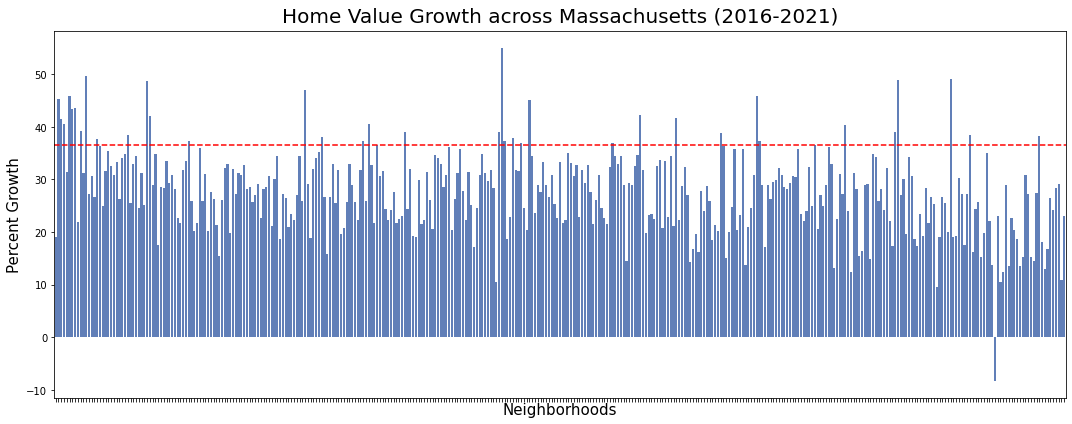

In [7]:
# Plot Growth per Neighborhood
################################

# Set figure size
fig, ax = plt.subplots(figsize=(15,6))

# Plot barplot
ax = sns.barplot(x="city", y="growth", data=df_housing_pct, color='#527bc6')

# Hide city labels
temp = ax.xaxis.get_ticklabels()
for label in temp:
    label.set_visible(False)
    
# Customize plot
ax.set_title("Home Value Growth across Massachusetts (2016-2021)",fontsize=20, pad=10)
ax.set_xlabel("Neighborhoods",fontsize=15)
ax.set_ylabel("Percent Growth",fontsize=15)
ax.axhline(y=df_housing_pct.growth.quantile(.90), 
           color='r', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('_images/home_value_growth_barplot.png')

plt.show()

<br><br>

### High Growth Locations

<br>

In [8]:
# Plot Map of Top Growth Neighborhoods

# Filter for top locations
df_housing_top = df_housing_pct[df_housing_pct.growth >= 
                                df_housing_pct.growth.quantile(.90)]

# Create list of top neighborhoods
top_list = df_housing_top.city.to_list()

# Create dataframe that filters for only top neighborhoods
top_neighborhoods = df_neighborhood[df_neighborhood['primary_city'].isin(top_list)]


# Create map of Boston using latitude and longitude values outlined previously
map_Top = folium.Map(location=[latitude, longitude], zoom_start=8.4)

# Add markers to map
for lat, lng, city in zip(top_neighborhoods['latitude'], 
                          top_neighborhoods['longitude'], 
                          top_neighborhoods['primary_city']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Top)  
    
map_Top


<br>

## 2.3) Foursquare Data

<a id='foursquare'></a>

This section includes the wrangling of Foursquare data using the [Foursquare API](https://developer.foursquare.com)

In [9]:
# FourSquare Configurations
#############################


CLIENT_ID = 'WNU2DFNXQJAOKHG3OGIUHW02MWRT2251NE5LY1DWCJU0KMD3' # Foursquare ID
CLIENT_SECRET = '3J5AGI0ATN3K5AOZPRPZH5UHRQ3Z3LY3BY2MWPFZCQRR3GQO' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

# Get Venue data from FourSquare
#################################

# Define helper function to pull venue data per borough
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


# Use function
mass_venues = getNearbyVenues(names      = top_neighborhoods['primary_city'],
                              latitudes  = top_neighborhoods['latitude'],
                              longitudes = top_neighborhoods['longitude'])

# Print data
mass_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Warren,42.21,-72.19,"Commins Pond Warren, Ma",42.207385,-72.193405,Beach
1,Warren,42.21,-72.19,XFINITY Store by Comcast,42.213381,-72.192997,Business Service
2,Warren,42.21,-72.19,Cakettes,42.212785,-72.194619,Bakery
3,Warren,42.21,-72.19,Mason's Grill,42.212946,-72.194502,American Restaurant
4,Springfield,42.11,-72.53,Band Room,42.108330,-72.526772,Rock Club


<br>

Now that we've gotten venue data, we can identify potential competition in the top growth neighborhoods.

<br>

In [10]:
# Identify competition
competitive_venues = ['Gym', 'Gym / Fitness Center']
df_competition = mass_venues[mass_venues['Venue Category'].isin(competitive_venues)]
df_competition.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
55,Springfield,42.12,-72.49,Hec's G.T.L. ROOM,42.117908,-72.485996,Gym
100,Athol,42.59,-72.23,Main Street Gym,42.593510,-72.229126,Gym
198,Worcester,42.24,-71.84,Planet Fitness,42.241386,-71.843071,Gym / Fitness Center
224,Worcester,42.32,-71.80,Anytime Fitness,42.324220,-71.798010,Gym / Fitness Center
534,Haverhill,42.78,-71.08,YMCA,42.777467,-71.079016,Gym


<br><br>

In [11]:
# Plot Map of Competitors


# Create map of Boston using latitude and longitude values outlined previously
map_Comp = folium.Map(location=[latitude, longitude], zoom_start=8.4)

# Add markers to map
for lat, lng, city in zip(df_competition['Neighborhood Latitude'], 
                          df_competition['Neighborhood Longitude'], 
                          df_competition['Neighborhood']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        parse_html=False).add_to(map_Comp)  
    
map_Comp

<br><br>

# 2) Clustering
<a id='clustering'></a>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<br>

## 2.1) Data Prepation
<a id='dataprep'></a>

In [24]:
# Data Encoding
###################

# One hot encoding
onehot = pd.get_dummies(mass_venues[['Venue Category']],
                       prefix = '', prefix_sep='')

# Add neighborhood column back to DF
onehot['Neighborhood'] = mass_venues['Neighborhood']

# Group records by Neighborhood & average the values per venue
venues_grouped = onehot.groupby('Neighborhood').mean().reset_index()

# Check Data
venues_grouped.head()

,Neighborhood,ATM,American Restaurant,Animal Shelter,Antique Shop,Arcade,Art Gallery,Asian Restaurant,Auto Garage,Auto Workshop,...,Trail,Train Station,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfall,Weight Loss Center,Wings Joint,Women's Store
0,Athol,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,Auburn,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.076923
2,Brockton,0.0,0.0,0.0,0.0,0.0,0.0,0.097561,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,Colrain,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,Dudley,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [25]:
# Build dataframe of most common venues per neighborhood
########################################################

# Create a function to get the most frequent/common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Build dataframe
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in tqdm(np.arange(num_top_venues)):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in tqdm(np.arange(venues_grouped.shape[0])):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

100%|██████████| 31/31 [00:00<00:00, 2051.78it/s]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Athol,Pizza Place,Department Store,Liquor Store,Social Club,Gastropub
1,Auburn,Clothing Store,Women's Store,Video Game Store,Shopping Mall,Shoe Store
2,Brockton,Gym / Fitness Center,Latin American Restaurant,Gas Station,Chinese Restaurant,Lounge
3,Colrain,Miscellaneous Shop,ATM,Paintball Field,Multiplex,Music Store
4,Dudley,Historic Site,ATM,Paper / Office Supplies Store,Multiplex,Music Store


<br><br>

## 2.2) Clustering Algorithm
<a id='algorithm'></a>

In [26]:
# Clustering
#############

# set number of clusters
kclusters = 25

# drop string column
mass_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mass_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# copy over original locations DF
mass_merged = top_neighborhoods

# rename columns
mass_merged.columns = ['Zip', 'Neighborhood', 'Latitude', 'Longitude']

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
mass_merged = mass_merged.join(neighborhoods_venues_sorted
                                       .set_index('Neighborhood'), 
                                       on='Neighborhood')

# Drop all NA values
mass_merged.dropna(inplace=True)

# Conver cluster label column into Integer data type
mass_merged.loc[:,'Cluster Labels'] = mass_merged.loc[:,'Cluster Labels'].astype(int)

In [27]:
# Map the clusters
###################
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8.3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mass_merged['Latitude'], 
                                  mass_merged['Longitude'], 
                                  mass_merged['Neighborhood'], 
                                  mass_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [28]:
# Print out all locations, their clusters, and their most common venues for
# further analysis.

pd.set_option('display.max_rows', 100)
mass_merged.reset_index(drop=True)

,Zip,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1083,Warren,42.21,-72.19,13,Bakery,American Restaurant,Beach,Business Service,Park
1,1101,Springfield,42.11,-72.53,1,Rock Club,Donut Shop,Pizza Place,Café,American Restaurant
2,1102,Springfield,42.11,-72.53,1,Rock Club,Donut Shop,Pizza Place,Café,American Restaurant
3,1103,Springfield,42.10,-72.59,1,Rock Club,Donut Shop,Pizza Place,Café,American Restaurant
4,1104,Springfield,42.13,-72.57,1,Rock Club,Donut Shop,Pizza Place,Café,American Restaurant
5,1105,Springfield,42.10,-72.58,1,Rock Club,Donut Shop,Pizza Place,Café,American Restaurant
6,1107,Springfield,42.12,-72.61,1,Rock Club,Donut Shop,Pizza Place,Café,American Restaurant
7,1108,Springfield,42.08,-72.56,1,Rock Club,Donut Shop,Pizza Place,Café,American Restaurant
8,1109,Springfield,42.11,-72.53,1,Rock Club,Donut Shop,Pizza Place,Café,American Restaurant
9,1111,Springfield,42.11,-72.53,1,Rock Club,Donut Shop,Pizza Place,Café,American Restaurant
